In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from scipy.fft import fft, fftfreq,rfft,fftshift
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.svm import SVC
import seaborn as sb
from sklearn.decomposition import PCA

In [2]:
df=pd.read_csv('dataset.csv')
df.drop('Unnamed',axis=1,inplace=True)
df['y'].replace({1:1,2:0,3:0,4:0,5:0},inplace=True)
x_train,x_test,y_train,y_test=train_test_split(df.drop(columns=['y']),df['y'],train_size=0.8,random_state=42,shuffle=True)

In [3]:
normalized_signal=pd.DataFrame(preprocessing.normalize(df.drop(columns=['y'])),columns=df.columns[:-1])

stat_features=pd.DataFrame()
stat_features['std']=x_train.std(axis='columns')
stat_features['mean']=x_train.mean(axis='columns')
stat_features['first difference']=x_train.diff(axis='columns').abs().T.mean()
stat_features['first difference normalized']=normalized_signal.diff(axis='columns').diff(axis='columns').abs().T.mean()
stat_features['second difference']=x_train.diff(axis='columns').diff(axis='columns').abs().T.mean()
stat_features['second difference normalized']=normalized_signal.diff(axis='columns').abs().T.mean()
stat_features['y']=y_train

stat_features

,std,mean,first difference,first difference normalized,second difference,second difference normalized,y
11351,104.294922,-50.415730,25.632768,0.008468,13.056818,0.016623,1
11220,50.657468,-78.432584,21.570621,0.013955,17.369318,0.017330,0
3403,40.536348,-17.825843,6.316384,0.007779,4.585227,0.010716,0
3827,144.340503,4.382022,24.000000,0.006935,13.323864,0.012492,1
5613,60.787137,-4.483146,23.480226,0.030794,24.971591,0.028955,0
...,...,...,...,...,...,...,...
11284,25.099432,-1.202247,8.135593,0.025052,8.375000,0.024335,0
5191,224.855916,6.348315,48.129944,0.006039,18.073864,0.016082,1
5390,114.650703,-61.960674,38.632768,0.010860,18.840909,0.022268,0
860,129.808687,49.387640,32.768362,0.011536,21.323864,0.017728,1


In [4]:
#isprobavati sa drugim stepenima regresije

rows=[]
for i in range(len(x_train)):
    model=AutoReg(x_train.iloc[i].values,lags=6).fit()
    row={}
    for j in range(1,7):
        row[f"param {j}"]=model.params[j]
    row['y']=y_train.iloc[i]
    rows.append(row)
ar_model_params=pd.DataFrame(rows)
ar_model_params

,param 1,param 2,param 3,param 4,param 5,param 6,y
0,2.274807,-1.766309,0.158191,0.550295,-0.298447,0.032895,1
1,1.963313,-1.891643,1.475359,-1.183833,0.567043,-0.062416,0
2,1.734679,-0.541256,-0.525348,0.237601,0.180337,-0.107928,0
3,2.156431,-1.766405,0.693924,-0.167621,0.042709,-0.026219,1
4,1.303381,-0.438412,-0.005039,-0.105786,-0.044148,0.062978,0
...,...,...,...,...,...,...,...
9195,1.444951,-0.503046,-0.280290,0.160420,0.208359,-0.119824,0
9196,2.498691,-2.157701,0.289906,0.793455,-0.595507,0.130599,1
9197,2.164647,-1.639109,0.006874,0.742098,-0.447742,0.027321,0
9198,2.378364,-2.092073,0.288790,0.959091,-0.764746,0.196568,1


In [5]:
rows=[]
for i in range(len(x_train)):
    frequencies=rfft(x_train.iloc[i])
    row={str(i+1):frequencies[i] for i in range(0,len(frequencies))}
    row['y']=y_train.iloc[i]
    rows.append(row)
f_transform=pd.DataFrame(rows)

rows=[]
for i in range(len(x_test)):
    rows.append(rfft(x_test.iloc[i]))
f_transform_test=pd.DataFrame(rows)
f_transform

,1,2,3,4,5,6,7,8,9,10,...,82,83,84,85,86,87,88,89,90,y
0,-8974.0+ 0.0j,-1695.926809+1177.570860j,-956.799269+4260.678360j,-1892.652318+3699.607536j,-2486.833954+4208.949250j,4178.539675+2434.270148j,4098.703133+ 2655.231894j,811.785515+ 1162.573150j,554.975273-2455.236660j,1194.761371+ 191.924969j,...,50.121375+ 13.547584j,65.297513+ 26.847810j,41.610615+ 36.415207j,40.660716+ 4.269391j,27.570380- 47.699419j,84.191143- 1.768261j,26.264479+ 35.989958j,41.774611+ 3.927348j,52.0+ 0.0j,1
1,-13961.0+ 0.0j,1182.420943-1196.964683j,-153.929865+ 745.373302j,1390.513654- 685.946036j,356.892030+ 248.741279j,1363.615031+ 911.934042j,-555.832881+ 251.250095j,-271.592798+ 720.825049j,-389.327502+ 479.030327j,1203.866162+1338.003647j,...,-58.400342+ 4.337256j,-71.552351+ 14.315534j,-48.430637- 20.488357j,-85.810197+ 15.131542j,-59.223170- 16.521888j,-66.208610- 10.552666j,-66.203747+ 10.726532j,-60.441902- 13.729841j,-61.0+ 0.0j,0
2,-3173.0+ 0.0j,-1691.054621-2212.800524j,1569.670681+1154.412998j,1916.096091+ 823.065735j,-491.908122+ 446.919296j,-47.695361+ 839.208065j,706.950637+ 1745.146278j,685.370938- 500.678347j,-401.823839+ 173.377302j,-264.059701+ 77.872153j,...,-93.950272+ 16.266491j,-84.831679- 8.054666j,-61.469428- 5.565473j,-62.561714- 11.995515j,-64.122347- 15.163868j,-51.314125+ 25.183539j,-79.432984+ 27.200299j,-73.162649+ 17.831314j,-45.0+ 0.0j,0
3,780.0+ 0.0j,1639.340749+2134.430919j,6071.252564-2861.643257j,-2644.892510- 472.799396j,-4256.687555-2022.450054j,3091.195128+7302.209469j,-971.041185+ 1838.786468j,6093.079259- 2030.179424j,-3744.450343-2657.715335j,-1452.263843-4636.551248j,...,2.950585- 15.620390j,-87.366886- 5.935140j,-42.794360+ 41.346582j,-31.122451+ 9.157655j,20.478880+ 16.181963j,1.414460+ 7.196826j,-35.317596- 29.876766j,-23.165066- 21.139057j,-20.0+ 0.0j,1
4,-798.0+ 0.0j,-393.558064+1621.172042j,245.891611+1993.571376j,1039.821276-1179.412583j,703.454976+ 770.488920j,862.328096-1446.098350j,785.953871- 1195.514111j,-968.612375- 1114.083592j,1490.572002- 261.394840j,-426.029867+1518.329184j,...,88.979638+ 2.727736j,56.219877+ 2.641237j,100.542384+ 26.413555j,89.166538- 15.313110j,172.609474- 60.858390j,-99.499759- 2.521413j,-75.927028-150.138286j,52.247019- 12.167742j,22.0+ 0.0j,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9195,-214.0+ 0.0j,1569.694323-1130.850919j,-791.571165+ 636.865029j,555.641893+ 253.889884j,144.853834+ 104.425855j,-184.865541- 22.641053j,773.244210+ 54.642942j,-679.715577- 530.361007j,498.233605+ 266.055334j,-53.573871+ 189.811294j,...,44.785068+ 31.015525j,14.344586- 3.753662j,-14.754166- 13.855858j,17.894618+ 17.463721j,-13.532574+ 9.927780j,0.672625- 24.605848j,10.960533+ 12.897335j,27.623879+ 2.755562j,22.0+ 0.0j,0
9196,1130.0+ 0.0j,-399.816212- 713.646350j,-1548.690587+ 597.363159j,647.790911+3218.833385j,-4200.329516+2777.531649j,-3087.243786+4362.330976j,12445.806809+16012.977887j,-10527.619979- 6684.159562j,-6854.615481-2097.607563j,-190.774086+2765.763406j,...,-38.310182- 32.008868j,8.096641+ 3.050316j,-70.635127- 65.582978j,2.896987- 4.851696j,-35.974604+ 33.582001j,26.019042- 56.738532j,-30.167635+ 37.988183j,-34.535224- 8.758800j,46.0+ 0.0j,1
9197,-11029.0+ 0.0j,-1288.191747+1606.953880j,-729.762439+ 646.073509j,896.976177-2100.127751j,1083.338532+1872.242228j,40.856501+1145.604953j,-929.859843- 1719.360617j,-452.985920+ 80.978980j,-1117.595748+ 721.057418j,-1562.734029- 317.985131j,...,110.629434- 11.402078j,101.922823- 25.030118j,90.067118- 16.285468j,101.897406- 25.375427j,140.707106- 17.499277j,111.809945+ 14.139280j,62.040903- 7.687831j,117.553610+ 31.633951j,153.0+ 0.0j,0
9198,8791.0+ 0.0j,165.217033+ 904.944333j,5975.474868-6165.314351j,1636.256947+4735.548264j,490.627630+7352.231075j,-2555.988181+ 279.200880j,-2723.440381+ 557.232550j,3519.316829- 2992.789459j,-842.601992+ 482.661758j,-2028.104078+ 701.569205j,...,-72.324498+ 35.470699j,-4.492508- 0.455788j,-121.334400+ 17.568432j,-57.361576+ 40.421865j,-38.200917+ 2.56

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=True, with_std=True)
x_scaled = scaler.fit_transform(abs(f_transform.drop(columns=['y'])))
df_scaled = pd.DataFrame(x_scaled, columns=f_transform.drop(columns=['y']).columns)
df_scaled['y']=f_transform['y'].values


def plot_correlation_for_col(df, col_name):
    plt.figure(figsize=(12,6)) # podesimo velicinu grafika
    correlation_matrix = df.corr() # racunamo matricu korelacije
    sorted_col_corr = correlation_matrix[col_name].sort_values(ascending=True) # indeksiramo kolonu i soritramo vrednosti
    sorted_col_corr = sorted_col_corr.drop(col_name) # izbacujemo vrednost samu sa sobom
    sb.barplot(x=sorted_col_corr.index, y=sorted_col_corr.values, palette='RdBu')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

#plot_correlation_for_col(abs(f_transform.drop(columns=[str(i) for i in range(20,91)])), col_name='y')
#plot_correlation_for_col(df_scaled, col_name='y')
df_scaled.describe()
pd.set_option('display.max_columns', 10)
df_scaled.head()

             1         2         3         4         5         6         7         8         9        10  ...        82        83        84        85        86        87        88        89        90  y
0     1.130148 -0.303405  0.262573  0.286963  0.408841  0.311991  0.317683 -0.249773  0.069781 -0.256738  ... -0.272807 -0.113073 -0.234694 -0.356449 -0.233035  0.005257 -0.324471 -0.342451 -0.203695  1
1     2.365938 -0.403295 -0.554812 -0.314678 -0.493947 -0.256458 -0.424373 -0.379589 -0.475921 -0.059076  ... -0.216995 -0.093400 -0.257543  0.032517 -0.179293 -0.136204 -0.135337 -0.176291 -0.130366  0
2    -0.307353 -0.115124 -0.285643 -0.191147 -0.447408 -0.398753 -0.203348 -0.363859 -0.527524 -0.570014  ...  0.092157  0.008271 -0.180485 -0.164555 -0.142237 -0.217655  0.006594 -0.065734 -0.260728  0
3    -0.900344 -0.139606  0.794185 -0.052251  0.373164  0.862333 -0.169223  0.753322  0.665663  0.966034  ... -0.575543  0.027829 -0.199173 -0.427451 -0.476860 -0.628275 -0.310146 -0.43040

,1,2,3,4,5,...,87,88,89,90,y
0,1.130148,-0.303405,0.262573,0.286963,0.408841,...,0.005257,-0.324471,-0.342451,-0.203695,1
1,2.365938,-0.403295,-0.554812,-0.314678,-0.493947,...,-0.136204,-0.135337,-0.176291,-0.130366,0
2,-0.307353,-0.115124,-0.285643,-0.191147,-0.447408,...,-0.217655,0.006594,-0.065734,-0.260728,0
3,-0.900344,-0.139606,0.794185,-0.052251,0.373164,...,-0.628275,-0.310146,-0.430402,-0.464419,1
4,-0.895883,-0.407020,-0.271994,-0.309635,-0.370643,...,0.131527,0.714687,-0.245472,-0.448124,0


ukupna varijansa: 86.8%


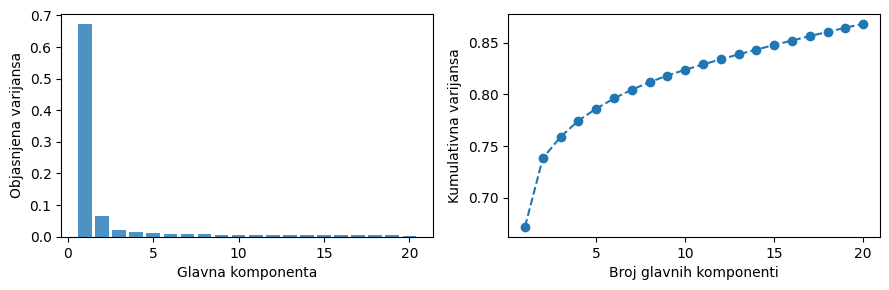

In [45]:
#da li za pca treba da se deli na train i test nakon pravljenja


# pravimo PCA model
pca_model = PCA(n_components=20, random_state=42)
# primenjujemo PCA na originalne atribute
principal_components = pca_model.fit_transform(df_scaled.drop(columns=['y']))
# procenat informacija koji smo sačuvali iz originalnih podataka
print(f'ukupna varijansa: {sum(pca_model.explained_variance_ratio_) * 100:.1f}%')

def plot_explained_variance(pca_model):
    '''Plots the explained variance plot using a trained PCA model.'''
    plt.figure(figsize=(9,3)) # podesimo velicinu grafika
    
    explained_variance = pca_model.explained_variance_ratio_
    cumulative_variance = explained_variance.cumsum()

    plt.subplot(1, 2, 1)
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.8, align='center')
    plt.xlabel('Glavna komponenta')
    plt.ylabel('Objasnjena varijansa')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, '--o')
    plt.xlabel('Broj glavnih komponenti')
    plt.ylabel('Kumulativna varijansa')

    plt.tight_layout()
    plt.show()

plot_explained_variance(pca_model)

C:\Users\mijat\AppData\Local\Temp\ipykernel_26672\1905262399.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.barplot(x=sorted_loading.index, y=sorted_loading.values, palette='Reds')


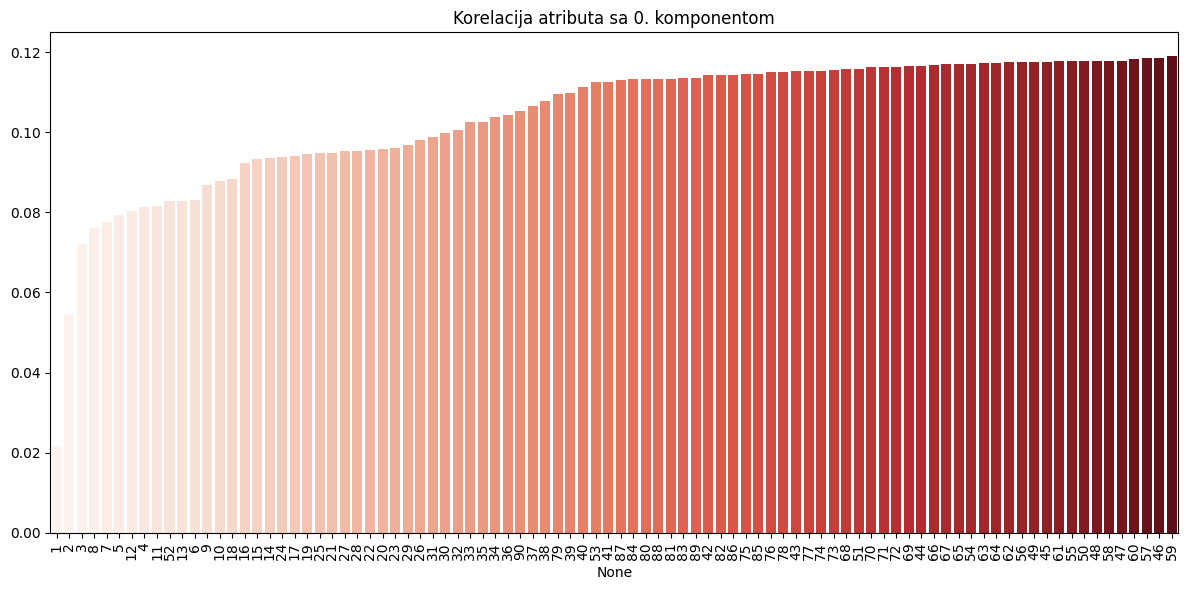

In [37]:
def plot_pc_loading(pca_model, pc_idx, columns, largest_n_pc=None):
    plt.figure(figsize=(12,6)) # podesimo velicinu grafika

    pc_loadings_df = pd.DataFrame(data=pca_model.components_, columns=columns)
    loading = pc_loadings_df.iloc[pc_idx]
    sorted_loading_abs = loading.abs().sort_values(ascending=True)

    largest_n_pc = 0 if largest_n_pc is None else largest_n_pc
    sorted_loading = loading[sorted_loading_abs.index][-largest_n_pc:]
    sb.barplot(x=sorted_loading.index, y=sorted_loading.values, palette='Reds')
    plt.xticks(rotation=90);
    plt.title(f'Korelacija atributa sa {pc_idx}. komponentom')
    plt.tight_layout()
    plt.show()

plot_pc_loading(pca_model, 0, df_scaled.drop(columns=['y']).columns)

In [16]:
svc=SVC()

c = [1.0,10.0,100.0,500.0,1000.0]
gamma = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
degree = [2,3,4]
param_grid=[{'C': c,'kernel': ['linear']},
            {'C': c,'kernel': ['rbf'],'gamma': gamma} ,
            {'C': c,'kernel': ['poly'],'gamma': gamma,'degree': degree}
           ]

grid_search = GridSearchCV(estimator=svc, 
                           param_grid=param_grid, 
                           scoring='f1', 
                           refit=True, 
                           n_jobs=-1, 
                           verbose=4)


best_result=grid_search.fit(abs(f_transform),y_train)

Fitting 5 folds for each of 185 candidates, totalling 925 fits


: 

In [12]:
print(best_result.best_params_)
print(best_result.best_score_)
print(best_result.score)
print(f'The accuracy score for the testing dataset is {grid_search.score(abs(f_transform_test), y_test):.4f}')

{'C': 2, 'gamma': 'scale', 'kernel': 'rbf'}
0.9615976445028945
<bound method BaseSearchCV.score of GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 2], 'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'poly']},
             refit='f1', scoring=['f1'], verbose=10)>
The accuracy score for the testing dataset is 0.9761
